In [1]:
import tensorflow as tf
import pandas as pd
from datetime import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, TimeDistributed, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from utils import *
from forecaster import Forecaster
import matplotlib.pyplot as plt
import itertools
import time
import scienceplots
plt.style.use(['science','no-latex', 'grid', 'nature'])
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn import metrics
from statsmodels.tsa.stattools import pacf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
import threading

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# gpu = tf.config.list_physical_devices("GPU")
# tf.config.set_visible_devices(gpu, 'GPU')

tf.config.set_visible_devices([], 'GPU')

In [2]:
# read all data
# run get_count_timeseries.py, get_holidays.py, get_lockdown.py, join_holiday_lockdown.py scripts to prepare data
df = pd.read_csv('flight_count_holiday_lockdown.csv')
df['time'] = pd.to_datetime(df['time'])
df['is_covid'] = ((df['time'] > "2020-01-24") & (df['time'] < "2021-12-01")).astype(int)

# Setting up loss function and forecaster object

In [3]:
def root_mean_squared_log_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

mse = MeanSquaredError()

forecaster = Forecaster(
    df[(df['time'] > "2017-01-01") & (df['time'] < "2023-08-01")], 
    x = 'time', 
    y = 'size', 
    group_features = ['country'],
    categorical_features = ['dayofmonth', 'quarter'],
    scoring_metric = metrics.mean_squared_error
)

## XGBoost

,XGBRegressor
Scaled training score,0.003416
Scaled test score,0.054303


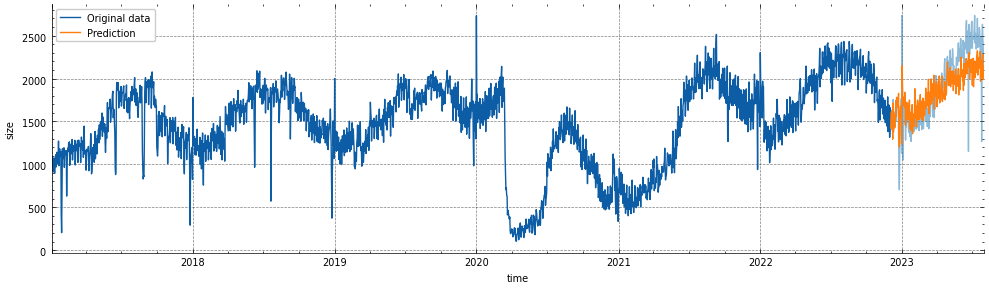

In [7]:
history, model, pred, score, ax = forecaster.validate(
    XGBRegressor(), 
    seasonality = True, 
    plot = True,
    split = 0.9
)
display(score[2:])

## 2 Layer LSTM (See below for gridsearch)

,LSTM
Scaled training score,0.002663
Scaled test score,0.057749


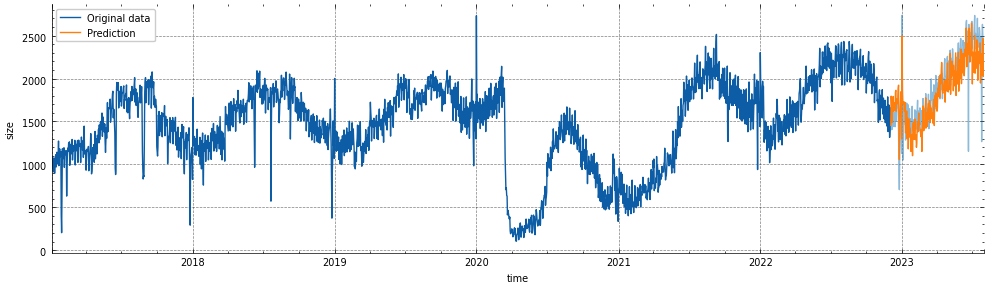

In [6]:
model = Sequential([
    LSTM(units = 100, return_sequences = True),
    Dropout(0.1),
    LSTM(units = 60),
    Dropout(0.1),
    Dense(units = 1)
], name = 'LSTM')

model.compile(optimizer = Adam(), loss = MeanSquaredError())
fit_kwargs = {'epochs': 100, 'batch_size': 128, 'verbose': 0}

history, model, pred, score, ax = forecaster.validate(
    model, 
    seasonality = True, 
    plot = True, 
    fit_kwargs = fit_kwargs,
    split = 0.9
)
display(score[2:])

# Grid Search

In [70]:
def parameter_grid(layers= [], layer_models = [], layers_param_grid = [], train_param_grid = {}):

    if max(layers) > len(layers_param_grid):
        raise "Number of layers exceeds number of layer parameter grids passed"
        
    # Get all possible combinations of NN layers
    combinations = []
    for n_layers in layers:
        combinations += itertools.product(layer_models, repeat=n_layers)
                            
    architectures = []
    for combination in combinations:
        architecture = {}
        for i_layer, arch_layer in enumerate(combination):
            layer_params = {'model': [arch_layer]} | layers_param_grid[i_layer]
            if i_layer != len(combination)-1:
                layer_params['return_sequences'] = [True]
            else:
                layer_params['return_sequences'] = [False]
                            
            architecture[i_layer] = list(ParameterGrid(
                layer_params
            ))
        
        architectures.append(architecture)
    
    param_grid = list(ParameterGrid(
        train_param_grid | {'arch': list(ParameterGrid(architectures))}
    ))
    
    param_grid_increasing_NN = 
    for p in param_grid:
        init =1 1e10
        for i in p["arch"]:
            if p["arch"][i]["units"] > init:
                del p[""]
    
    for p in param_grid:
        p['arch_name'] = ">".join([f"""{str(p["arch"][i]["model"]).split(".")[-1].split("'")[0]}{p["arch"][i]["units"]}""" for i in p["arch"]])
                            
    return param_grid   

In [104]:
def split_handler(split, model, fit_kwargs, scorer, index, results):
    forecaster = Forecaster(
        split, 
        x = 'time', 
        y = 'size', 
        group_features = ['country'],
        categorical_features = ['dayofmonth', 'quarter'],
        scoring_metric = scorer
    )

    a = time.time()
    result = forecaster.validate(
        model, 
        seasonality = True,
        fit_kwargs = fit_kwargs
    )
    b = time.time()

    result += (b-a,)
    results[index] = result

def grid_search_nn(df, scorer, cv, param_grid, n_threads = 1):
    # Get date splits
    dates = df['time'].unique()
    split_dates = pd.date_range(df['time'].min(), df['time'].max(), periods=cv+1)
    splits = [
        df[(df['time'] >= split_dates[i]) & (df['time'] <= split_dates[i+1])] \
        for i in range(len(split_dates) - 1)
    ]
    
    counter = 0
    threads = []
    results = {}
    
    start = time.time()
    for param in param_grid:
        sequence = []
        for i in param['arch']:
            sequence.append(
                param['arch'][i]['model'](
                    units = param['arch'][i]['units'],
                    return_sequences = param['arch'][i]['return_sequences']
                )
            )
            sequence.append(Dropout(0.1))
        sequence.append(Dense(units = 1))
        name = param['arch_name']
        
        model = Sequential(sequence, name = name)
        model.compile(optimizer = Adam(), loss = MeanSquaredError())
        fit_kwargs = {'epochs': param['epochs'], 'batch_size': param['batch_size'], 'verbose': 0}

        for i_split, split in enumerate(splits):
            print(
                f"""{counter+1}/{len(splits)*len(param_grid)}: {name}, split_{i_split}, epochs={param['epochs']}, batch_size={param['batch_size']}""",
                end="\r"
            )
            
            index = (name, param['batch_size'], param['epochs'], f'split_{i_split}', 'time')
            
            while counter - len(results) >= n_threads:
                time.sleep(1)
            
            thread = threading.Thread(target=split_handler, args=(split, model, fit_kwargs, scorer, index, results,))
            thread.start()
            threads.append(
                thread
            )
            counter += 1
        
    for thread in threads:
        thread.join()
        
    end = time.time()
        
    return results, end-start

In [103]:
param_grid = parameter_grid(
    layers = [1, 2],
    layer_models = [LSTM, GRU],
    layers_param_grid = [{'units': [100, 150]}, {'units': [60, 100]}],
    train_param_grid = {'epochs': [100, 200], 'batch_size': [32, 128]}
)
results, exec_time = grid_search_nn(df, scorer=metrics.mean_squared_error, cv=5, param_grid=param_grid, n_threads=5)

In [145]:
scores = [results[result][3] for result in results]
indexes = [result[:-2] for result in results]
splits = [result[-2] for result in results]
exec_times = [results[result][-1] for result in results]

In [299]:
index = pd.MultiIndex.from_tuples(indexes, names=['Model', 'Batch size', 'Epochs'])
grid = pd.DataFrame(
    ([score.values.flatten()[2:] for score in scores]), 
    columns=['Training score', 'Test score'],
    index=index
)

grid['Split'] = splits
grid['Execution time (s)'] = exec_times

grid = pd.melt(grid.reset_index(), id_vars=['Model', 'Batch size', 'Epochs', 'Split'], value_vars=['Training score', 'Test score', 'Execution time (s)'])
mean_df = grid.groupby(['Model', 'Batch size', 'Epochs', 'variable'], as_index=False)['value'].mean() 
mean_df['Split'] = 'Mean'
std_df = grid.groupby(['Model', 'Batch size', 'Epochs', 'variable'], as_index=False)['value'].std()
std_df['Split'] = 'Standard deviation'

grid = grid.pivot_table(index=['Model', 'Batch size', 'Epochs'], columns=['Split', 'variable'], values='value').reindex(['Training score', 'Test score', 'Execution time (s)'], level='variable', axis=1)
mean_df = mean_df.pivot_table(index=['Model', 'Batch size', 'Epochs'], columns=['Split', 'variable'], values='value').reindex(['Training score', 'Test score', 'Execution time (s)'], level='variable', axis=1)
std_df = std_df.pivot_table(index=['Model', 'Batch size', 'Epochs'], columns=['Split', 'variable'], values='value').reindex(['Training score', 'Test score'], level='variable', axis=1)

grid = pd.concat([mean_df, std_df, grid], axis=1)

In [307]:
grid.sort_values([('Mean', 'Execution time (s)')]).reset_index()[
    grid.sort_values([('Mean', 'Execution time (s)')]).reset_index()['Model'] == \
    "LSTM100>LSTM60"
]

Split              Model Batch size Epochs           Mean             \
variable                                   Training score Test score   
8         LSTM100>LSTM60        128    100       0.002296   0.271617   
26        LSTM100>LSTM60        128    200       0.001228   0.339765   
39        LSTM100>LSTM60         32    100       0.001802   0.414268   
64        LSTM100>LSTM60         32    200       0.000804   0.469150   

Split                       Standard deviation                   split_0  \
variable Execution time (s)     Training score Test score Training score   
8                 14.253503           0.000551   0.239281       0.002501   
26                21.353193           0.000148   0.352594       0.001369   
39                26.177304           0.000584   0.507737       0.002155   
64                43.477850           0.000150   0.607309       0.000887   

Split                                         split_1             \
variable Test score Execution time (s) Training score Test score   
8          0.677344          14.212787       0.002719   0.084235   
26         0.955880          19.499313       0.001182   0.093647   
39         1.307389          26.151449       0.001401   0.077240   
64         1.540748          43.443549       0.000843   0.076898   

Split                              split_2                                \
variable Execution time (s) Training score Test score Execution time (s)   
8                 14.272785       0.002306   0.293322          14.379891   
26                21.816832       0.001358   0.302041          21.832557   
39                26.178561       0.002023   0.334756          26.187693   
64                43.521589       0.000881   0.354764          43.536504   

Split           split_3                                      split_4  \
variable Training score Test score Execution time (s) Training score   
8              0.002607   0.149246          14.386637       0.001350   
26             0.001227   0.157916          21.812775       0.001006   
39             0.002429   0.171006          26.179543       0.001003   
64             0.000872   0.201515          43.436960       0.000537   

Split                                   
variable Test score Execution time (s)  
8          0.153936          14.015416  
26         0.189341          21.804487  
39         0.180950          26.189275  
64         0.171824          43.450649

In [317]:
grid.sort_values([('Mean', 'Test score')])[['Mean', 'Standard deviation']].head()

Split                                       Mean             \
variable                          Training score Test score   
Model           Batch size Epochs                             
LSTM100>LSTM60  128        100          0.002296   0.271617   
LSTM150>LSTM100 128        100          0.002150   0.276615   
LSTM100>LSTM100 128        100          0.002572   0.280945   
GRU100          128        100          0.005093   0.282721   
LSTM150>GRU100  128        100          0.002420   0.296087   

Split                                                Standard deviation  \
variable                          Execution time (s)     Training score   
Model           Batch size Epochs                                         
LSTM100>LSTM60  128        100             14.253503           0.000551   
LSTM150>LSTM100 128        100             17.031967           0.000540   
LSTM100>LSTM100 128        100             14.815283           0.000663   
GRU100          128        100              8.554641           0.001672   
LSTM150>GRU100  128        100             16.322591           0.000249   

Split                                         
variable                          Test score  
Model           Batch size Epochs             
LSTM100>LSTM60  128        100      0.239281  
LSTM150>LSTM100 128        100      0.251289  
LSTM100>LSTM100 128        100      0.254216  
GRU100          128        100      0.226439  
LSTM150>GRU100  128        100      0.299474

In [ ]:
grid.sort_values([('Mean', 'Execution time (s)')])[['Mean', 'Standard deviation']].head(10)

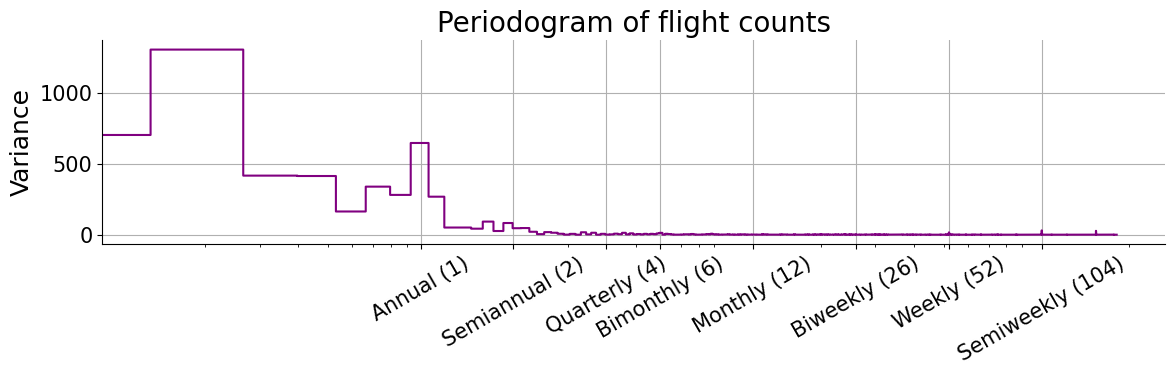

In [9]:
plt.style.use('default')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
freqencies, spectrum = periodogram(
        df.dropna().groupby('time')['size'].mean(),
        fs=365,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(12, 4))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([1, 2, 4, 6, 12, 26, 52, 104],
          [
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
    ],rotation=30)
plt.ylabel("Variance")
plt.grid()
plt.title("Periodogram of flight counts")
plt.tight_layout()
plt.savefig('plots/seasonality.png', bbox_inches=None, dpi=150)